# PyMEOS Demo for ACM Demo

In [4]:
from functools import partial

import contextily as cx
import pandas as pd
import pyproj
import shapely as shp
from matplotlib import pyplot as plt
from pymeos import *
from pymeos.plotters import TemporalPointSequencePlotter, TemporalSequencePlotter
from shapely.ops import transform
from tqdm.auto import tqdm
import plotly.express as px

tqdm.pandas()
pymeos_initialize()

## Preprocessing

In [2]:
raw = pd.read_csv('singapore.csv', header=0,
                  names=['ID', 'Trajectory ID', 'Driving Mode', 'OS Name', 'Timestamp', 'Latitude', 'Longitude',
                         'Speed', 'Bearing', 'Accuracy'],
                  usecols=['Trajectory ID', 'Timestamp', 'Latitude', 'Longitude', 'Speed', 'Bearing', 'Accuracy'])
raw.head()

Trajectory ID   Timestamp  Latitude   Longitude      Speed  Bearing   
0          70014  1554943236  1.342326  103.888969  18.910000      248  \
1          73573  1555582623  1.321781  103.856366  17.719076       44   
2          75567  1555141026  1.327088  103.861273  14.021548       34   
3           1410  1555731693  1.262482  103.823794  13.026521      181   
4           4354  1555584497  1.283799  103.807210  14.812943       93   

   Accuracy  
0       3.9  
1       4.0  
2       3.9  
3       4.0  
4       3.9

We preprocess the row data so that:
- Rows that have null values are deleted.
- Timestamps are converted from millis since epoch to `datetime` objects.
- A new column with Shapely Points is generated.
- Points are transformed from EPSG:4326 to EPSG:3414

In [7]:
raw = raw.dropna()
raw['Timestamp'] = pd.to_datetime(raw['Timestamp'], origin='unix', unit='s')
raw['Location'] = shp.points(raw['Longitude'], raw['Latitude'])
raw.head()

Trajectory ID           Timestamp  Latitude   Longitude      Speed   
0          70014 2019-04-11 00:40:36  1.342326  103.888969  18.910000  \
1          73573 2019-04-18 10:17:03  1.321781  103.856366  17.719076   
2          75567 2019-04-13 07:37:06  1.327088  103.861273  14.021548   
3           1410 2019-04-20 03:41:33  1.262482  103.823794  13.026521   
4           4354 2019-04-18 10:48:17  1.283799  103.807210  14.812943   

   Bearing  Accuracy                       Location  
0      248       3.9   POINT (103.888969 1.3423256)  
1       44       4.0  POINT (103.8563664 1.3217811)  
2       34       3.9  POINT (103.8612733 1.3270883)  
3      181       4.0  POINT (103.8237941 1.2624821)  
4       93       3.9   POINT (103.8072101 1.283799)

In [8]:
wgs84 = pyproj.CRS('EPSG:4326')
svy21 = pyproj.CRS('EPSG:3414')

project = partial(transform, pyproj.Transformer.from_crs(wgs84, svy21, always_xy=True).transform)

raw['Location'] = raw['Location'].progress_map(project)
raw.head()

  0%|          | 0/9096633 [00:00<?, ?it/s]

Trajectory ID           Timestamp  Latitude   Longitude      Speed   
0          70014 2019-04-11 00:40:36  1.342326  103.888969  18.910000  \
1          73573 2019-04-18 10:17:03  1.321781  103.856366  17.719076   
2          75567 2019-04-13 07:37:06  1.327088  103.861273  14.021548   
3           1410 2019-04-20 03:41:33  1.262482  103.823794  13.026521   
4           4354 2019-04-18 10:48:17  1.283799  103.807210  14.812943   

   Bearing  Accuracy                                       Location  
0      248       3.9    POINT (34193.28884111905 36053.13149951502)  
1       44       4.0   POINT (30564.99363142349 33781.367426346194)  
2       34       3.9   POINT (31111.076307488558 34368.21604473356)  
3      181       4.0   POINT (26939.99544875286 27224.380019454307)  
4       93       3.9  POINT (25094.341940912695 29581.505386669698)

## PyMEOS objects generation
Now, we use the original dataset to build the PyMEOS temporal objects.

In [9]:
trajectories = raw[['Trajectory ID', 'Timestamp']].copy()

We start by generating an instant object (`TFloatInst` and `TGeomPointInst`) from the original data

In [10]:
trajectories['Speed'] = raw.progress_apply(lambda row: TFloatInst(value=row['Speed'], timestamp=row['Timestamp']),
                                           axis=1)
trajectories['Bearing'] = raw.progress_apply(lambda row: TFloatInst(value=row['Bearing'], timestamp=row['Timestamp']),
                                             axis=1)
trajectories['Location'] = raw.progress_apply(
    lambda row: TGeomPointInst(point=row['Location'], timestamp=row['Timestamp']), axis=1)
trajectories.head()

  0%|          | 0/9096633 [00:00<?, ?it/s]

  0%|          | 0/9096633 [00:00<?, ?it/s]

  0%|          | 0/9096633 [00:00<?, ?it/s]

Trajectory ID           Timestamp                             Speed   
0          70014 2019-04-11 00:40:36      18.91@2019-04-11 00:40:36+02  \
1          73573 2019-04-18 10:17:03  17.719076@2019-04-18 10:17:03+02   
2          75567 2019-04-13 07:37:06  14.021548@2019-04-13 07:37:06+02   
3           1410 2019-04-20 03:41:33  13.026521@2019-04-20 03:41:33+02   
4           4354 2019-04-18 10:48:17  14.812943@2019-04-18 10:48:17+02   

                      Bearing   
0  248@2019-04-11 00:40:36+02  \
1   44@2019-04-18 10:17:03+02   
2   34@2019-04-13 07:37:06+02   
3  181@2019-04-20 03:41:33+02   
4   93@2019-04-18 10:48:17+02   

                                            Location  
0  POINT(34193.28884111905 36053.13149951502)@201...  
1  POINT(30564.99363142349 33781.367426346194)@20...  
2  POINT(31111.076307488558 34368.21604473356)@20...  
3  POINT(26939.99544875286 27224.380019454307)@20...  
4  POINT(25094.341940912695 29581.505386669698)@2...

In [12]:
t = trajectories[['Trajectory ID', 'Timestamp']].copy()
t['Speed'] = trajectories['Speed'].progress_map(lambda x: x.as_hexwkb())
t['Bearing'] = trajectories['Bearing'].progress_map(lambda x: x.as_hexwkb())
t['Location'] = trajectories['Location'].progress_map(lambda x: x.as_hexwkb())
t.to_csv('singapore_instants.csv', index=False)

  0%|          | 0/9096633 [00:00<?, ?it/s]

  0%|          | 0/9096633 [00:00<?, ?it/s]

  0%|          | 0/9096633 [00:00<?, ?it/s]

In [60]:
trajectories = pd.read_csv('singapore_instants.csv', parse_dates=['Timestamp'], converters={
    'Speed': TFloatInst.from_hexwkb,
    'Bearing': TFloatInst.from_hexwkb,
    'Location': partial(TGeomPointInst.from_hexwkb, srid=3414)
})
trajectories.head()

Trajectory ID           Timestamp                      Speed  \
0          70014 2019-04-11 00:40:36  18@2019-04-11 00:40:36+02   
1          73573 2019-04-18 10:17:03  17@2019-04-18 10:17:03+02   
2          75567 2019-04-13 07:37:06  14@2019-04-13 07:37:06+02   
3           1410 2019-04-20 03:41:33  13@2019-04-20 03:41:33+02   
4           4354 2019-04-18 10:48:17  14@2019-04-18 10:48:17+02   

                      Bearing  \
0  248@2019-04-11 00:40:36+02   
1   44@2019-04-18 10:17:03+02   
2   34@2019-04-13 07:37:06+02   
3  181@2019-04-20 03:41:33+02   
4   93@2019-04-18 10:48:17+02   

                                            Location  
0  010100000002BB2F3E29B2E0408E783E35A49AE140@201...  
1  01010000000B41A8973FD9DD4093E5F4C1AB7EE040@201...  
2  0101000000F3CD38E2C461DE4024A5D6E906C8E040@201...  
3  010100000098AF6EB5FF4EDA40061E3D521896DA40@201...  
4  01010000004C235CE29581D8408C54415860E3DC40@201...

Now, we sort the rows by time, and aggregate them by Trajectory ID, aggregating the columns in lists

In [13]:
trajectories = trajectories.sort_values(by='Timestamp').groupby('Trajectory ID').agg(list)
trajectories.head()

Timestamp   
Trajectory ID                                                      
2              [2019-04-09 02:38:49, 2019-04-09 02:38:51, 201...  \
3              [2019-04-12 08:32:16, 2019-04-12 08:32:42, 201...   
4              [2019-04-13 10:42:41, 2019-04-13 10:42:42, 201...   
5              [2019-04-20 01:39:11, 2019-04-20 01:39:16, 201...   
8              [2019-04-11 07:24:36, 2019-04-11 07:24:44, 201...   

                                                           Speed   
Trajectory ID                                                      
2              [25.457024@2019-04-09 02:38:49+02, 25.45879@20...  \
3              [0@2019-04-12 08:32:16+02, 5.639999866485596@2...   
4              [5.87@2019-04-13 10:42:41+02, 5.79@2019-04-13 ...   
5              [7.51663064956665@2019-04-20 01:39:11+02, 9.95...   
8              [13.21@2019-04-11 07:24:36+02, 4.3@2019-04-11 ...   

                                                         Bearing   
Trajectory ID                                                      
2              [97@2019-04-09 02:38:49+02, 93@2019-04-09 02:3...  \
3              [96@2019-04-12 08:32:16+02, 106@2019-04-12 08:...   
4              [214@2019-04-13 10:42:41+02, 213@2019-04-13 10...   
5              [84@2019-04-20 01:39:11+02, 66@2019-04-20 01:3...   
8              [319@2019-04-11 07:24:36+02, 317@2019-04-11 07...   

                                                        Location  
Trajectory ID                                                     
2              [POINT(30758.23769803839 28093.078111015366)@2...  
3              [POINT(29976.92276472283 29447.930733503224)@2...  
4              [POINT(31317.258396777648 37489.99111973874)@2...  
5              [POINT(21611.971370324743 35829.369713410284)@...  
8              [POINT(41327.009524107765 35147.23516406313)@2...

Finally, instants are merged into PyMEOS Sequences

In [14]:
trajectories['Speed'] = trajectories['Speed'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Bearing'] = trajectories['Bearing'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Trajectory'] = trajectories['Location'].progress_apply(
    lambda x: TGeomPointSeq(instant_list=x, upper_inc=True).set_srid(3414))
trajectories = trajectories.drop(['Location', 'Timestamp'], axis=1)

  0%|          | 0/28000 [00:00<?, ?it/s]

  0%|          | 0/28000 [00:00<?, ?it/s]

  0%|          | 0/28000 [00:00<?, ?it/s]

We store the DataFrame in a csv file to save the processing.
Sequence objects need to be transformed to text to be able to be parsed later.
HexWKB format is chosen here.

In [15]:
t = trajectories[['Speed', 'Bearing', 'Trajectory']].copy()
t['Speed'] = t['Speed'].map(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].map(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].map(lambda x: x.as_hexwkb())
t.to_csv('singapore_trajectories.csv')

## Extracting interesting trips

In [2]:
trajectories = pd.read_csv('singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
2              [25.457024@2019-04-09 02:38:49+02, 25.45879@20...  \
3              [0@2019-04-12 08:32:16+02, 5.639999866485596@2...   
4              [5.87@2019-04-13 10:42:41+02, 5.79@2019-04-13 ...   
5              [7.51663064956665@2019-04-20 01:39:11+02, 9.95...   
8              [13.21@2019-04-11 07:24:36+02, 4.3@2019-04-11 ...   

                                                         Bearing   
Trajectory ID                                                      
2              [97@2019-04-09 02:38:49+02, 93@2019-04-09 02:3...  \
3              [96@2019-04-12 08:32:16+02, 106@2019-04-12 08:...   
4              [214@2019-04-13 10:42:41+02, 212@2019-04-13 10...   
5              [84@2019-04-20 01:39:11+02, 66@2019-04-20 01:3...   
8              [319@2019-04-11 07:24:36+02, 317@2019-04-11 07...   

                                                      Trajectory  
Trajectory ID                                                     
2              [POINT(30758.23769803839 28093.078111015366)@2...  
3              [POINT(29976.92276472283 29447.930733503224)@2...  
4              [POINT(31317.258396777648 37489.99111973874)@2...  
5              [POINT(21611.971370324743 35829.369713410284)@...  
8              [POINT(41327.009524107765 35147.23516406313)@2...

We now plot the trajectories in a map to take an overall look at them.

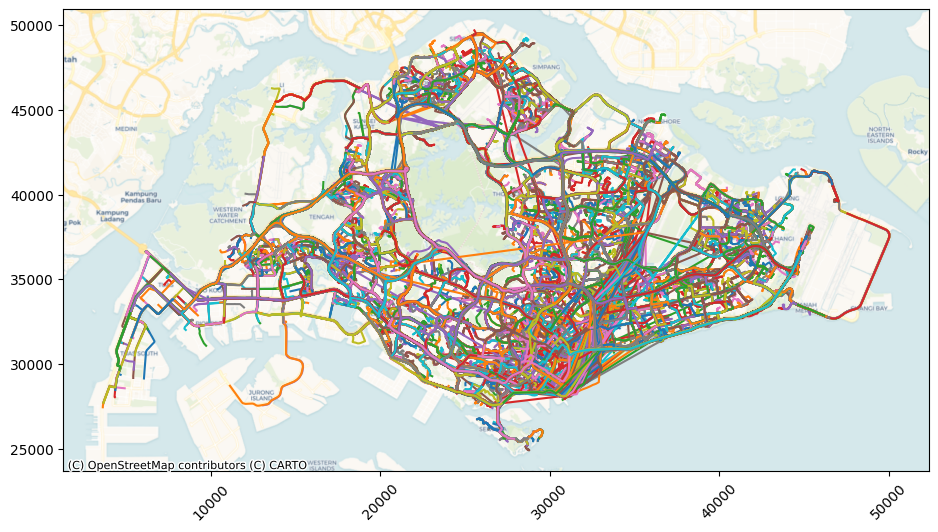

In [16]:
_, ax = plt.subplots(figsize=(12, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trajectories['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In this demo we will work over the ferries that do the route Rodby (Denmark) <-> Puttgarden (Germany), so we'll start creating a bounding box for each port.
We start by manually getting two points, one for each port, and creating a box for each. Then, we expand this bounding boxes.
From these two boxes we create another one that contains both. We'll use this bigger one ase a prefilter to detect the ferries.

In [3]:
# TODO: Change text above
bay = shp.set_srid(shp.Point(32232.5740, 30189.7942), 3414)
airport = shp.set_srid(shp.Point(44452.1091, 35088.7227), 3414)

bay_bb = STBox.from_geometry_time(bay, Period(lower='2019-04-08', upper='2019-04-22', upper_inc=True)).expand(1000)
airport_bb = STBox.from_geometry_time(airport, Period(lower='2019-04-08', upper='2019-04-22', upper_inc=True)).expand(
    1000)

joined_bb = (bay_bb + airport_bb).expand(100)

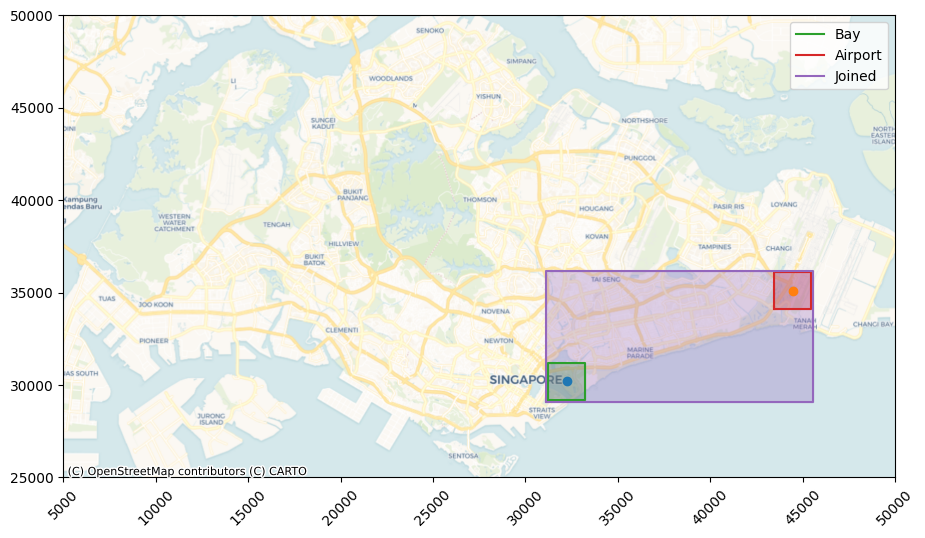

In [4]:
_, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(25000, 50000)
ax.set_xlim(5000, 50000)
_ = ax.plot(bay.x, bay.y, marker="o")
_ = ax.plot(airport.x, airport.y, marker="o")
_ = bay_bb.plot_xy(axes=ax, label='Bay')
_ = airport_bb.plot_xy(axes=ax, label='Airport')
_ = joined_bb.plot_xy(axes=ax, label='Joined')
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)
_ = plt.legend()

In [5]:
intersect_index = trajectories['Trajectory'].progress_map(lambda trip: trip.ever_intersects(joined_bb))
possible_trips = trajectories[intersect_index]
external_trips = trajectories[~intersect_index]

  0%|          | 0/28000 [00:00<?, ?it/s]

In [6]:
trips_index = possible_trips['Trajectory'].progress_map(lambda trip: trip.ever_intersects(bay_bb)
                                                                     and trip.ever_intersects(airport_bb))
trips = possible_trips[trips_index]
non_trips_internal = possible_trips[~trips_index]

  0%|          | 0/15942 [00:00<?, ?it/s]

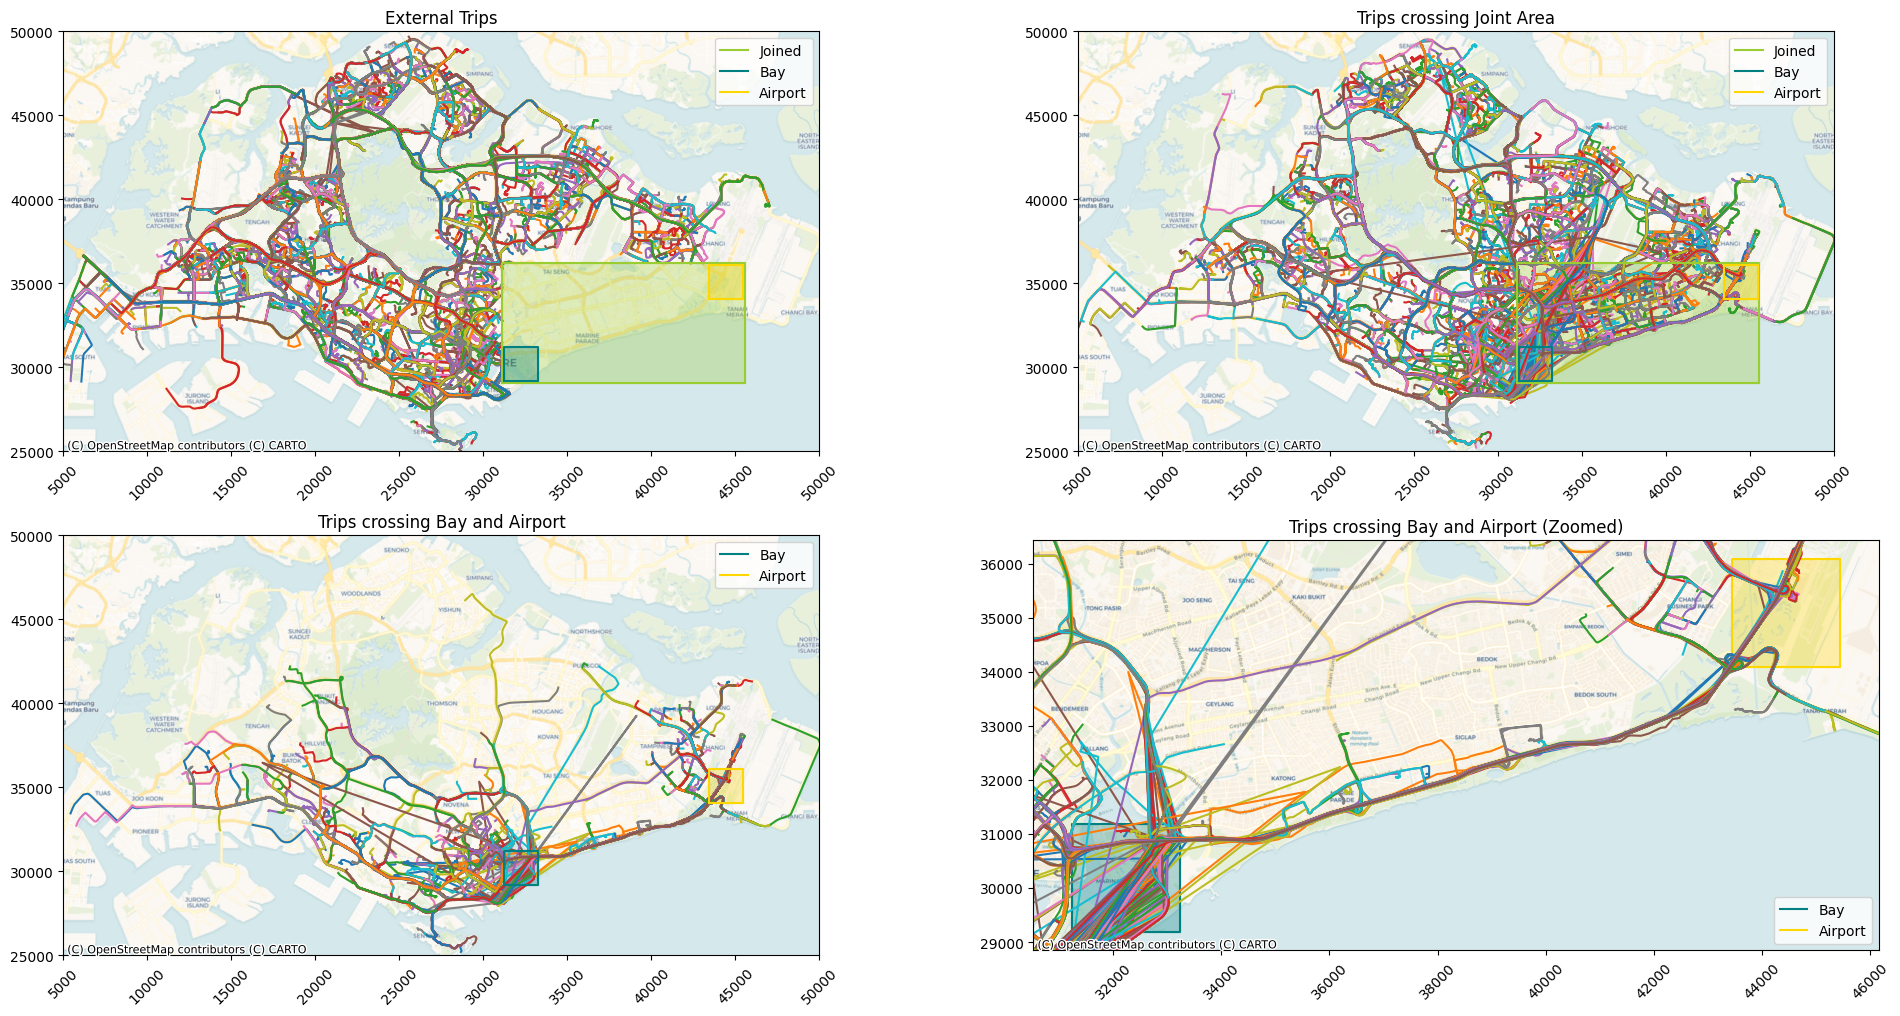

In [8]:
_, ax = plt.subplots(2, 2, figsize=(24, 12))
_ = TemporalPointSequencePlotter.plot_sequences_xy(external_trips['Trajectory'], axes=ax[0][0], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(possible_trips['Trajectory'], axes=ax[0][1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   show_grid=False)
ax[0][0].set_title('External Trips')
ax[0][1].set_title('Trips crossing Joint Area')
ax[1][0].set_title('Trips crossing Bay and Airport')
ax[1][1].set_title('Trips crossing Bay and Airport (Zoomed)')
_ = joined_bb.plot_xy(axes=ax[0][0], color='yellowgreen', label='Joined')
_ = joined_bb.plot_xy(axes=ax[0][1], color='yellowgreen', label='Joined')
for a in [ax[0][0], ax[0][1], ax[1][0]]:
    _ = bay_bb.plot_xy(axes=a, color='teal', label='Bay')
    _ = airport_bb.plot_xy(axes=a, color='gold', label='Airport')
    _ = a.set_ylim(25000, 50000)
    _ = a.set_xlim(5000, 50000)
    _ = cx.add_basemap(a, crs=3414, source=cx.providers.CartoDB.Voyager)
    _ = a.legend()
_ = bay_bb.plot_xy(axes=ax[1][1], color='teal', label='Bay')
_ = airport_bb.plot_xy(axes=ax[1][1], color='gold', label='Airport')
_ = cx.add_basemap(ax[1][1], crs=3414, source=cx.providers.CartoDB.Voyager)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][1], show_markers=False,
                                                   show_grid=False)
_ = plt.legend()

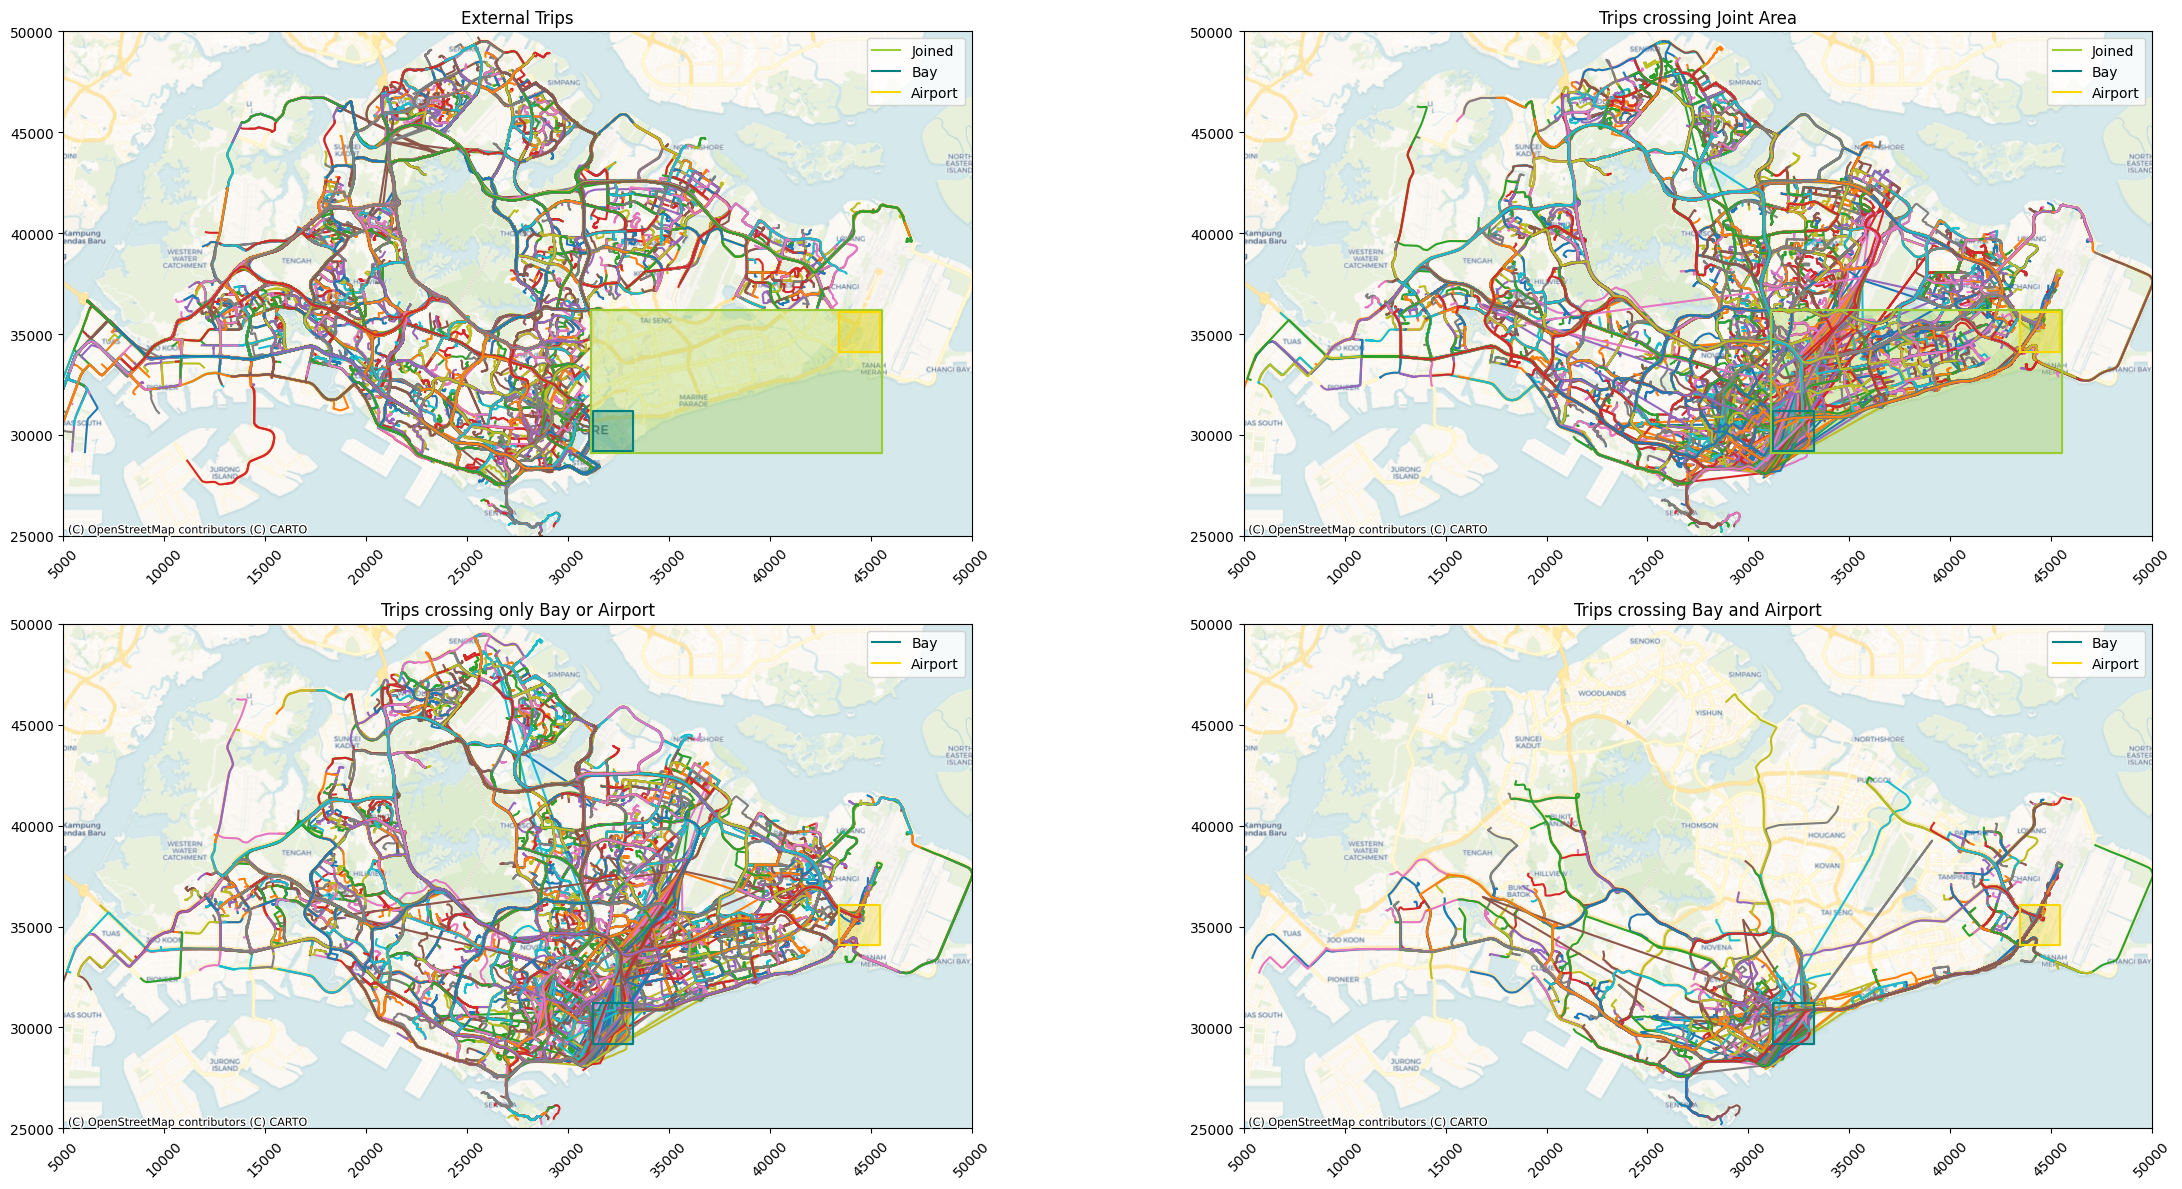

In [9]:
_, ax = plt.subplots(2, 2, figsize=(24, 12))
_ = TemporalPointSequencePlotter.plot_sequences_xy(external_trips['Trajectory'], axes=ax[0][0], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(possible_trips['Trajectory'], axes=ax[0][1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(non_trips_internal['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][1], show_markers=False,
                                                   show_grid=False)
ax[0][0].set_title('External Trips')
ax[0][1].set_title('Trips crossing Joint Area')
ax[1][0].set_title('Trips crossing only Bay or Airport')
ax[1][1].set_title('Trips crossing Bay and Airport')
_ = joined_bb.plot_xy(axes=ax[0][0], color='yellowgreen', label='Joined')
_ = joined_bb.plot_xy(axes=ax[0][1], color='yellowgreen', label='Joined')
for r in ax:
    for a in r:
        _ = bay_bb.plot_xy(axes=a, color='teal', label='Bay')
        _ = airport_bb.plot_xy(axes=a, color='gold', label='Airport')
        _ = a.set_ylim(25000, 50000)
        _ = a.set_xlim(5000, 50000)
        _ = cx.add_basemap(a, crs=3414, source=cx.providers.CartoDB.Voyager)
        _ = a.legend()
_ = plt.legend()
_ = plt.tight_layout()

In [11]:
t = trips.copy()
t['Speed'] = t['Speed'].apply(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].apply(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].apply(lambda x: x.as_hexwkb())
t.to_csv('trips.csv')

nt = pd.concat([
    external_trips.copy(),
    non_trips_internal.copy(),
])
nt['Speed'] = nt['Speed'].apply(lambda x: x.as_hexwkb())
nt['Bearing'] = nt['Bearing'].apply(lambda x: x.as_hexwkb())
nt['Trajectory'] = nt['Trajectory'].apply(lambda x: x.as_hexwkb())
nt.to_csv('non_trips.csv')

## Splitting trajectories into one-leg trips

In [7]:
trips = pd.read_csv('trips.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
non_trips = pd.read_csv('non_trips.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trips.head()

Speed   
Trajectory ID                                                      
3              [0@2019-04-12 08:32:16+02, 5.639999866485596@2...  \
17             [16.280000686645508@2019-04-10 09:09:45+02, 17...   
20             [19.36905860900879@2019-04-08 02:45:23+02, 19....   
58             [23.667463302612305@2019-04-14 10:38:01+02, 23...   
74             [16@2019-04-11 10:55:59+02, 17.25@2019-04-11 1...   

                                                         Bearing   
Trajectory ID                                                      
3              [96@2019-04-12 08:32:16+02, 106@2019-04-12 08:...  \
17             [111@2019-04-10 09:09:45+02, 96@2019-04-10 09:...   
20             [205@2019-04-08 02:45:23+02, 205@2019-04-08 02...   
58             [202@2019-04-14 10:38:01+02, 202@2019-04-14 10...   
74             [343@2019-04-11 10:55:59+02, 345@2019-04-11 10...   

                                                      Trajectory  
Trajectory ID                                                     
3              [POINT(29976.92276472283 29447.930733503224)@2...  
17             [POINT(29559.596664822402 28344.051744168963)@...  
20             [POINT(44279.64475527302 35372.198951828344)@2...  
58             [POINT(44446.613492697084 35743.57082003859)@2...  
74             [POINT(44131.53326592727 33850.61498803221)@20...

In [13]:
geometry_trips = trips.copy()
geometry_trips['Is Inside'] = geometry_trips['Trajectory'].map(
    lambda trip: trip.is_spatially_contained_in(bay_bb).temporal_or(
        trip.is_spatially_contained_in(airport_bb)))
geometry_trips['Time Inside'] = geometry_trips['Is Inside'].map(lambda t: t.when_true())
geometry_trips['Period'] = geometry_trips['Time Inside'].map(lambda t: t.to_period())
geometry_trips['Time Outside'] = geometry_trips.apply(lambda row: row['Is Inside'].at(row['Period']).when_false(), axis=1)
geometry_trips['Single Trips'] = geometry_trips.apply(lambda row: row['Trajectory'].at(row['Time Outside']), axis=1)
geometry_trips.head()

Speed   
Trajectory ID                                                      
3              [0@2019-04-12 08:32:16+02, 5.639999866485596@2...  \
17             [16.280000686645508@2019-04-10 09:09:45+02, 17...   
20             [19.36905860900879@2019-04-08 02:45:23+02, 19....   
58             [23.667463302612305@2019-04-14 10:38:01+02, 23...   
74             [16@2019-04-11 10:55:59+02, 17.25@2019-04-11 1...   

                                                         Bearing   
Trajectory ID                                                      
3              [96@2019-04-12 08:32:16+02, 106@2019-04-12 08:...  \
17             [111@2019-04-10 09:09:45+02, 96@2019-04-10 09:...   
20             [205@2019-04-08 02:45:23+02, 205@2019-04-08 02...   
58             [202@2019-04-14 10:38:01+02, 202@2019-04-14 10...   
74             [343@2019-04-11 10:55:59+02, 345@2019-04-11 10...   

                                                      Trajectory   
Trajectory ID                                                      
3              [POINT(29976.92276472283 29447.930733503224)@2...  \
17             [POINT(29559.596664822402 28344.051744168963)@...   
20             [POINT(44279.64475527302 35372.198951828344)@2...   
58             [POINT(44446.613492697084 35743.57082003859)@2...   
74             [POINT(44131.53326592727 33850.61498803221)@20...   

                                                       Is Inside   
Trajectory ID                                                      
3              {[f@2019-04-12 08:32:16+02, f@2019-04-12 08:36...  \
17             {[f@2019-04-10 09:09:45+02, f@2019-04-10 09:12...   
20             {[t@2019-04-08 02:45:23+02, f@2019-04-08 02:46...   
58             {[t@2019-04-14 10:38:01+02, f@2019-04-14 10:39...   
74             {[f@2019-04-11 10:55:59+02, f@2019-04-11 10:56...   

                                                     Time Inside   
Trajectory ID                                                      
3              {(2019-04-12 08:36:30.639356+02, 2019-04-12 08...  \
17             {(2019-04-10 09:12:35.75032+02, 2019-04-10 09:...   
20             {[2019-04-08 02:45:23+02, 2019-04-08 02:46:38....   
58             {[2019-04-14 10:38:01+02, 2019-04-14 10:39:21....   
74             {(2019-04-11 10:56:13.668573+02, 2019-04-11 10...   

                                                          Period   
Trajectory ID                                                      
3              (2019-04-12 08:36:30.639356+02, 2019-04-12 08:...  \
17             (2019-04-10 09:12:35.75032+02, 2019-04-10 09:2...   
20             [2019-04-08 02:45:23+02, 2019-04-08 02:56:46.5...   
58             [2019-04-14 10:38:01+02, 2019-04-14 10:49:10.1...   
74             (2019-04-11 10:56:13.668573+02, 2019-04-11 11:...   

                                                    Time Outside   
Trajectory ID                                                      
3              {[2019-04-12 08:37:55.726379+02, 2019-04-12 08...  \
17             {[2019-04-10 09:15:28.293558+02, 2019-04-10 09...   
20             {[2019-04-08 02:46:38.752935+02, 2019-04-08 02...   
58             {[2019-04-14 10:39:21.801152+02, 2019-04-14 10...   
74             {[2019-04-11 10:57:16.151339+02, 2019-04-11 11...   

                                                    Single Trips  
Trajectory ID                                                     
3              {[POINT(33232.57398324077 30889.990044942926)@...  
17             {[POINT(33232.573992867154 30892.96522326864)@...  
20             {[POINT(43452.10911109142 34147.62948637997)@2...  
58             {[POINT(43452.10910684249 34147.812942103395)@...  
74             {[POINT(43671.28258574524 34088.722706322376)@...

In [14]:
geometry_single_ferry_trips = geometry_trips[['Single Trips', 'Speed', 'Bearing']].copy()
geometry_single_ferry_trips['Single Trips'] = geometry_single_ferry_trips['Single Trips'].apply(
    lambda trip: trip.sequences())
geometry_single_ferry_trips = geometry_single_ferry_trips.explode('Single Trips').rename({'Single Trips': 'Trip'},
                                                                                         axis=1)
geometry_single_ferry_trips.insert(0, 'Trip #', geometry_single_ferry_trips.groupby('Trajectory ID').cumcount() + 1)
geometry_single_ferry_trips.head()

Trip #                                               Trip   
Trajectory ID                                                              
3                   1  [POINT(33232.57398324077 30889.990044942926)@2...  \
17                  1  [POINT(33232.573992867154 30892.96522326864)@2...   
20                  1  [POINT(43452.10911109142 34147.62948637997)@20...   
58                  1  [POINT(43452.10910684249 34147.812942103395)@2...   
74                  1  [POINT(43671.28258574524 34088.722706322376)@2...   

                                                           Speed   
Trajectory ID                                                      
3              [0@2019-04-12 08:32:16+02, 5.639999866485596@2...  \
17             [16.280000686645508@2019-04-10 09:09:45+02, 17...   
20             [19.36905860900879@2019-04-08 02:45:23+02, 19....   
58             [23.667463302612305@2019-04-14 10:38:01+02, 23...   
74             [16@2019-04-11 10:55:59+02, 17.25@2019-04-11 1...   

                                                         Bearing  
Trajectory ID                                                     
3              [96@2019-04-12 08:32:16+02, 106@2019-04-12 08:...  
17             [111@2019-04-10 09:09:45+02, 96@2019-04-10 09:...  
20             [205@2019-04-08 02:45:23+02, 205@2019-04-08 02...  
58             [202@2019-04-14 10:38:01+02, 202@2019-04-14 10...  
74             [343@2019-04-11 10:55:59+02, 345@2019-04-11 10...

In [15]:
geometry_single_ferry_trips['Speed'] = geometry_single_ferry_trips.apply(
    lambda row: row['Speed'].at(row['Trip'].period()), axis=1)
geometry_single_ferry_trips['Bearing'] = geometry_single_ferry_trips.apply(
    lambda row: row['Bearing'].at(row['Trip'].period()), axis=1)
geometry_single_ferry_trips.head()

Trip #                                               Trip   
Trajectory ID                                                              
3                   1  [POINT(33232.57398324077 30889.990044942926)@2...  \
17                  1  [POINT(33232.573992867154 30892.96522326864)@2...   
20                  1  [POINT(43452.10911109142 34147.62948637997)@20...   
58                  1  [POINT(43452.10910684249 34147.812942103395)@2...   
74                  1  [POINT(43671.28258574524 34088.722706322376)@2...   

                                                           Speed   
Trajectory ID                                                      
3              [24.137135422071932@2019-04-12 08:37:55.726379...  \
17             [17.392847189735413@2019-04-10 09:15:28.293558...   
20             [20.822357542431952@2019-04-08 02:46:38.752935...   
58             [22.69432296911621@2019-04-14 10:39:21.801152+...   
74             [19.358847454545455@2019-04-11 10:57:16.151339...   

                                                         Bearing  
Trajectory ID                                                     
3              [87.56840525@2019-04-12 08:37:55.726379+02, 87...  
17             [86.784407@2019-04-10 09:15:28.293558+02, 86@2...  
20             [214@2019-04-08 02:46:38.752935+02, 214@2019-0...  
58             [213@2019-04-14 10:39:21.801152+02, 213@2019-0...  
74             [238.10710172727272@2019-04-11 10:57:16.151339...

In [16]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))

_ = TemporalPointSequencePlotter.plot_sequences_xy(geometry_single_ferry_trips['Trip'], axes=ax[0])
_ = cx.add_basemap(ax[0], crs=3414, source=cx.providers.CartoDB.Voyager)

_ = TemporalSequencePlotter.plot_sequences(geometry_single_ferry_trips['Speed'], axes=ax[1])
_ = TemporalSequencePlotter.plot_sequences(geometry_single_ferry_trips['Bearing'], axes=ax[2])

Error in callback <function flush_figures at 0x7f6528520550> (for post_execute):


KeyboardInterrupt: 

In [86]:
old_geometry_trips = trips.copy()
old_geometry_trips['Time Outside'] = old_geometry_trips['Trajectory'].map(
    lambda trip: trip.is_spatially_contained_in(bay_bb).temporal_or(
        trip.is_spatially_contained_in(airport_bb)).when_false())
old_geometry_trips['Single Trips'] = old_geometry_trips.apply(lambda row: row['Trajectory'].at(row['Time Outside']), axis=1)

old_geometry_single_ferry_trips = old_geometry_trips[['Single Trips', 'Speed', 'Bearing']].copy()
old_geometry_single_ferry_trips['Single Trips'] = old_geometry_single_ferry_trips['Single Trips'].apply(
    lambda trip: trip.sequences())
old_geometry_single_ferry_trips = old_geometry_single_ferry_trips.explode('Single Trips').rename({'Single Trips': 'Trip'},
                                                                                         axis=1)
old_geometry_single_ferry_trips.insert(0, 'Trip #', old_geometry_single_ferry_trips.groupby('Trajectory ID').cumcount() + 1)

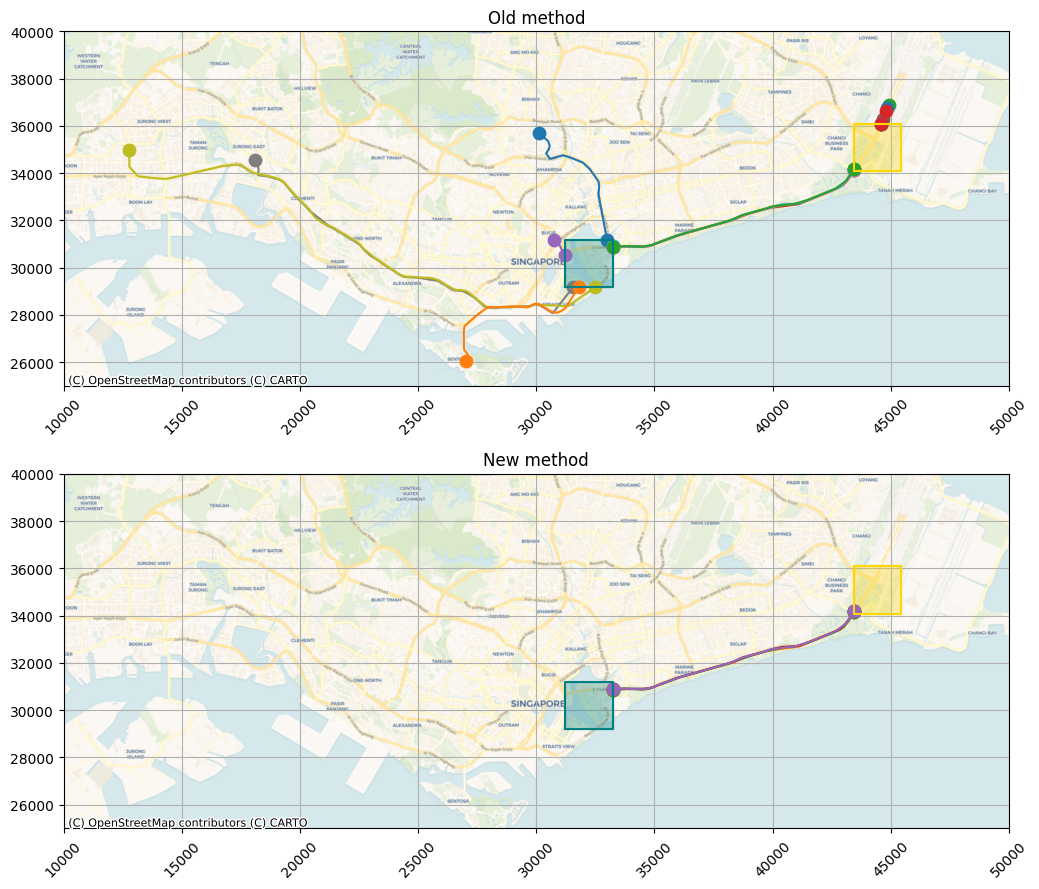

In [92]:
_, ax = plt.subplots(2, 1, figsize=(18, 9))

_ = TemporalPointSequencePlotter.plot_sequences_xy(old_geometry_single_ferry_trips['Trip'], axes=ax[0])
_ = bay_bb.plot_xy(axes=ax[0], color='teal', label='Bay')
_ = airport_bb.plot_xy(axes=ax[0], color='gold', label='Airport')
_ = ax[0].set_ylim(25000, 40000)
_ = ax[0].set_xlim(10000, 50000)
_ = cx.add_basemap(ax[0], crs=3414, source=cx.providers.CartoDB.Voyager)
_ = ax[0].set_title('Old method')

_ = TemporalPointSequencePlotter.plot_sequences_xy(geometry_single_ferry_trips['Trip'], axes=ax[1])
_ = bay_bb.plot_xy(axes=ax[1], color='teal', label='Bay')
_ = airport_bb.plot_xy(axes=ax[1], color='gold', label='Airport')
_ = ax[1].set_ylim(25000, 40000)
_ = ax[1].set_xlim(10000, 50000)
_ = cx.add_basemap(ax[1], crs=3414, source=cx.providers.CartoDB.Voyager)
_ = ax[1].set_title('New method')

plt.tight_layout()

## Trajectory Heatmap

In [93]:
trajectories = pd.read_csv('singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed  \
Trajectory ID                                                      
465            [15@2019-04-10 00:19:35+02, 18@2019-04-10 00:1...   
747            [9@2019-04-21 00:36:03+02, 16@2019-04-21 00:36...   
762            [15@2019-04-12 09:09:17+02, 16@2019-04-12 09:0...   
919            [9@2019-04-21 03:33:50+02, 10@2019-04-21 03:34...   
956            [1@2019-04-20 03:28:16+02, 4@2019-04-20 03:28:...   

                                                         Bearing  \
Trajectory ID                                                      
465            [23@2019-04-10 00:19:35+02, 11@2019-04-10 00:1...   
747            [56@2019-04-21 00:36:03+02, 56@2019-04-21 00:3...   
762            [210@2019-04-12 09:09:17+02, 207@2019-04-12 09...   
919            [194@2019-04-21 03:33:50+02, 178@2019-04-21 03...   
956            [62@2019-04-20 03:28:16+02, 85@2019-04-20 03:2...   

                                                      Trajectory  
Trajectory ID                                                     
465            [POINT(24296.288156699997 31060.45338081872)@2...  
747            [POINT(18156.78415713992 40500.977093451256)@2...  
762            [POINT(27529.133460302295 43387.95524864778)@2...  
919            [POINT(29822.584007745212 45098.37193180107)@2...  
956            [POINT(29346.20242105811 46534.71649322525)@20...

In [8]:
bbox: STBox = TemporalPointExtentAggregator.aggregate(trips['Trajectory'])

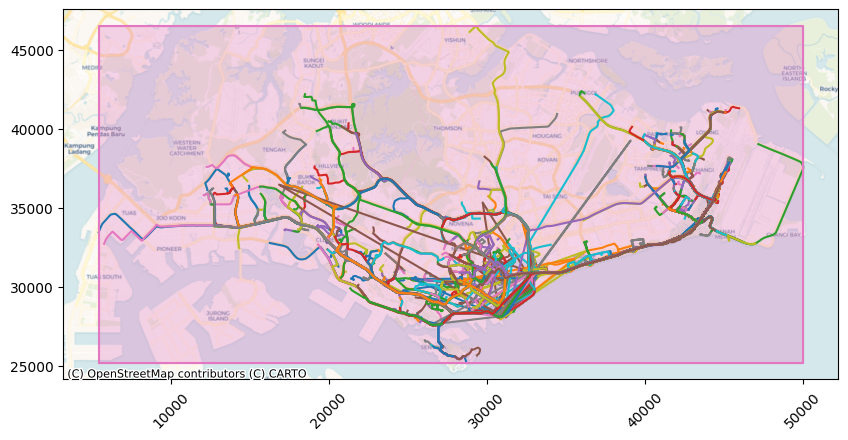

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = bbox.plot_xy(axes=ax)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In [12]:
heat_df = pd.DataFrame(data={'Tile': bbox.tile_flat(size=500)})
heat_df['# Trajectories'] = heat_df['Tile'].progress_map(lambda tile: sum(trips['Trajectory'].map(lambda tp: tp.ever_intersects(tile))))
heat_df['X'] = heat_df['Tile'].map(lambda tile: (tile.xmin() + tile.xmax()) / 2)
heat_df['Y'] = heat_df['Tile'].map(lambda tile: (tile.ymin() + tile.ymax()) / 2)
heat_df.head()

  0%|          | 0/4004 [00:00<?, ?it/s]

Tile  # Trajectories       X   
0  SRID=3414;STBOX X((5000,25000),(5500,25500))               0  5250.0  \
1  SRID=3414;STBOX X((5500,25000),(6000,25500))               0  5750.0   
2  SRID=3414;STBOX X((6000,25000),(6500,25500))               0  6250.0   
3  SRID=3414;STBOX X((6500,25000),(7000,25500))               0  6750.0   
4  SRID=3414;STBOX X((7000,25000),(7500,25500))               0  7250.0   

         Y  
0  25250.0  
1  25250.0  
2  25250.0  
3  25250.0  
4  25250.0

In [13]:
svy21 = pyproj.CRS('EPSG:3414')
wgs84 = pyproj.CRS('EPSG:4326')

project = partial(transform, pyproj.Transformer.from_crs(svy21, wgs84, always_xy=True).transform)

heat_df['Coords'] = pd.Series(shp.points(heat_df['X'], heat_df['Y'])).map(project)
heat_df['Lat'] = heat_df['Coords'].map(lambda p: p.y)
heat_df['Lon'] = heat_df['Coords'].map(lambda p: p.x)
heat_df.head()

Tile  # Trajectories       X   
0  SRID=3414;STBOX X((5000,25000),(5500,25500))               0  5250.0  \
1  SRID=3414;STBOX X((5500,25000),(6000,25500))               0  5750.0   
2  SRID=3414;STBOX X((6000,25000),(6500,25500))               0  6250.0   
3  SRID=3414;STBOX X((6500,25000),(7000,25500))               0  6750.0   
4  SRID=3414;STBOX X((7000,25000),(7500,25500))               0  7250.0   

         Y                                         Coords       Lat   
0  25250.0  POINT (103.62890438417908 1.2446185400661418)  1.244619  \
1  25250.0   POINT (103.6333969852848 1.2446188866543217)  1.244619   
2  25250.0   POINT (103.63788958762865 1.244619225541259)  1.244619   
3  25250.0  POINT (103.64238219118279 1.2446195567269431)  1.244620   
4  25250.0   POINT (103.6468747959194 1.2446198802113633)  1.244620   

          Lon  
0  103.628904  
1  103.633397  
2  103.637890  
3  103.642382  
4  103.646875

In [30]:
heat_df.to_csv('heatmap.csv', index=False)

In [2]:
heat_df = pd.read_csv('heatmap.csv')

In [14]:
fig = px.density_mapbox(heat_df, lat = 'Lat', lon = 'Lon', z = '# Trajectories',
                        radius = 20,
                        zoom = 11,
                        mapbox_style = 'open-street-map',
                        width=1300,
                        height=800,
                        )
fig.show()

In [4]:
fig.write_image('heatmap.png')

## Metric extraction

In [19]:
trajectories = pd.read_csv('singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
2              [25.457024@2019-04-09 02:38:49+02, 25.45879@20...  \
3              [0@2019-04-12 08:32:16+02, 5.639999866485596@2...   
4              [5.87@2019-04-13 10:42:41+02, 5.79@2019-04-13 ...   
5              [7.51663064956665@2019-04-20 01:39:11+02, 9.95...   
8              [13.21@2019-04-11 07:24:36+02, 4.3@2019-04-11 ...   

                                                         Bearing   
Trajectory ID                                                      
2              [97@2019-04-09 02:38:49+02, 93@2019-04-09 02:3...  \
3              [96@2019-04-12 08:32:16+02, 106@2019-04-12 08:...   
4              [214@2019-04-13 10:42:41+02, 212@2019-04-13 10...   
5              [84@2019-04-20 01:39:11+02, 66@2019-04-20 01:3...   
8              [319@2019-04-11 07:24:36+02, 317@2019-04-11 07...   

                                                      Trajectory  
Trajectory ID                                                     
2              [POINT(30758.23769803839 28093.078111015366)@2...  
3              [POINT(29976.92276472283 29447.930733503224)@2...  
4              [POINT(31317.258396777648 37489.99111973874)@2...  
5              [POINT(21611.971370324743 35829.369713410284)@...  
8              [POINT(41327.009524107765 35147.23516406313)@2...

In [23]:
trajectories['Distance'] = trajectories['Trajectory'].map(lambda t: t.length())
trajectories['Avg Speed'] = trajectories['Speed'].map(lambda s: s.time_weighted_average())
trajectories['Avg Direction'] = trajectories['Bearing'].map(lambda b: b.time_weighted_average())
trajectories['Travel Time'] = trajectories['Trajectory'].map(lambda t: t.duration())
trajectories.head()

Speed   
Trajectory ID                                                      
2              [25.457024@2019-04-09 02:38:49+02, 25.45879@20...  \
3              [0@2019-04-12 08:32:16+02, 5.639999866485596@2...   
4              [5.87@2019-04-13 10:42:41+02, 5.79@2019-04-13 ...   
5              [7.51663064956665@2019-04-20 01:39:11+02, 9.95...   
8              [13.21@2019-04-11 07:24:36+02, 4.3@2019-04-11 ...   

                                                         Bearing   
Trajectory ID                                                      
2              [97@2019-04-09 02:38:49+02, 93@2019-04-09 02:3...  \
3              [96@2019-04-12 08:32:16+02, 106@2019-04-12 08:...   
4              [214@2019-04-13 10:42:41+02, 212@2019-04-13 10...   
5              [84@2019-04-20 01:39:11+02, 66@2019-04-20 01:3...   
8              [319@2019-04-11 07:24:36+02, 317@2019-04-11 07...   

                                                      Trajectory   
Trajectory ID                                                      
2              [POINT(30758.23769803839 28093.078111015366)@2...  \
3              [POINT(29976.92276472283 29447.930733503224)@2...   
4              [POINT(31317.258396777648 37489.99111973874)@2...   
5              [POINT(21611.971370324743 35829.369713410284)@...   
8              [POINT(41327.009524107765 35147.23516406313)@2...   

                   Distance  Avg Speed  Avg Direction  Travel Time  
Trajectory ID                                                       
2              27890.427764  19.101550     191.660408         1518  
3              16766.660893  14.865332      62.108377         1158  
4              18021.383541  13.216388     179.506259         1358  
5              18676.865856  12.963250     107.375472         1325  
8              15934.905801  13.143426     244.417978         1207

## Close cars identification

In [5]:
trajectories = pd.read_csv('singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
2              [25.457024@2019-04-09 02:38:49+02, 25.45879@20...  \
3              [0@2019-04-12 08:32:16+02, 5.639999866485596@2...   
4              [5.87@2019-04-13 10:42:41+02, 5.79@2019-04-13 ...   
5              [7.51663064956665@2019-04-20 01:39:11+02, 9.95...   
8              [13.21@2019-04-11 07:24:36+02, 4.3@2019-04-11 ...   

                                                         Bearing   
Trajectory ID                                                      
2              [97@2019-04-09 02:38:49+02, 93@2019-04-09 02:3...  \
3              [96@2019-04-12 08:32:16+02, 106@2019-04-12 08:...   
4              [214@2019-04-13 10:42:41+02, 212@2019-04-13 10...   
5              [84@2019-04-20 01:39:11+02, 66@2019-04-20 01:3...   
8              [319@2019-04-11 07:24:36+02, 317@2019-04-11 07...   

                                                      Trajectory  
Trajectory ID                                                     
2              [POINT(30758.23769803839 28093.078111015366)@2...  
3              [POINT(29976.92276472283 29447.930733503224)@2...  
4              [POINT(31317.258396777648 37489.99111973874)@2...  
5              [POINT(21611.971370324743 35829.369713410284)@...  
8              [POINT(41327.009524107765 35147.23516406313)@2...

In [16]:
data = []
for i, trip in trajectories['Trajectory'].items():
    for j, other in trajectories['Trajectory'].items():
        if j <= i:
            continue
        if trip.is_ever_within_distance(other, 10):
            print(f'{i} within {j}')
            data.append((i, trip, j, other))

2 within 47828
3 within 74200
4 within 62283
5 within 32083
5 within 39851
5 within 63422
5 within 65664
5 within 75039
9 within 82701
11 within 11633
11 within 28124
11 within 31135
15 within 59642
15 within 63819
20 within 68600
21 within 77413
21 within 79812
23 within 12118
23 within 41952
23 within 52510
23 within 74277
27 within 25481
27 within 61194
27 within 79776
31 within 59251
31 within 66691
31 within 73169
35 within 69982
35 within 70163
37 within 38475
37 within 62943
41 within 5511
41 within 45315
44 within 9376
44 within 29528
47 within 26201
48 within 676
48 within 50880
49 within 62844
51 within 46710
52 within 11115
52 within 24739
52 within 59925
52 within 67140
52 within 77495
60 within 4172
60 within 26277
60 within 35865
61 within 17601
62 within 29934
62 within 63216
62 within 77911
65 within 53932
67 within 13273
67 within 29743
67 within 56596
75 within 46644
77 within 67747
78 within 22193
78 within 35219
79 within 65859
81 within 28431
83 within 2536
83 with

In [13]:
TGeomPointSeq

pymeos.main.tpoint.TGeomPointSeq

In [17]:
close_cars = pd.DataFrame(data, columns=['ID 1', 'Trajectory 1', 'ID 2', 'Trajectory 2'])
close_cars.head()

ID 1                                       Trajectory 1   ID 2   
0     2  [POINT(30758.23769803839 28093.078111015366)@2...  47828  \
1     3  [POINT(29976.92276472283 29447.930733503224)@2...  74200   
2     4  [POINT(31317.258396777648 37489.99111973874)@2...  62283   
3     5  [POINT(21611.971370324743 35829.369713410284)@...  32083   
4     5  [POINT(21611.971370324743 35829.369713410284)@...  39851   

                                        Trajectory 2  
0  [POINT(18515.090309324245 42262.47897626746)@2...  
1  [POINT(42848.51596142612 38651.706696576155)@2...  
2  [POINT(32427.881885213705 30893.28380823192)@2...  
3  [POINT(29255.428402229667 39931.25026224207)@2...  
4  [POINT(34243.14128345968 33833.07555037253)@20...

In [18]:
close_cars.to_csv('close_cars.csv', index=False)